In [1]:
import pandas as pd
import sqlite3
import matplotlib
%matplotlib inline

### Creating Helper Functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT * FROM sqlite_master 
    WHERE type IN ("table","view");
    '''
    df = run_query(q)
    return df[['name','type']]


#run_query('DROP VIEW view_name;')


In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Selecting Albums to Purchase
Write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.

In [4]:
#run_command('DROP VIEW genre_quant;')

In [5]:
c = '''
CREATE VIEW genre_quant AS
SELECT il.track_id, il.quantity, t.genre_id, g.name, i.billing_country
FROM invoice_line il
INNER JOIN track t on t.track_id = il.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
INNER JOIN invoice i on i.invoice_id = il.invoice_id
'''
run_command(c)

OperationalError: table genre_quant already exists

In [6]:
q = '''
WITH usa_tracks AS
(
SELECT name,
       quantity,
       billing_country
FROM genre_quant
WHERE billing_country="USA"
)
SELECT name genre,
       sum(quantity) total_sold,
       CAST(sum(quantity) AS float)/
       (SELECT sum(quantity)
       FROM genre_quant 
       WHERE billing_country="USA") AS percentage
FROM usa_tracks
GROUP BY genre
ORDER BY total_sold DESC
'''
df = run_query(q)
df.head(30)

,genre,total_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


###  Analyzing Employee Sales Performance

In [7]:
q = '''
SELECT e.employee_id,
       e.first_name,
       e.title,
       e.hire_date,
       e.birthdate,
       e.city,
       e.reports_to,
       SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i on i.customer_id = c.customer_id
GROUP BY e.employee_id
'''

run_query(q)

,employee_id,first_name,title,hire_date,birthdate,city,reports_to,total_sales
0,3,Jane,Sales Support Agent,2017-04-01 00:00:00,1973-08-29 00:00:00,Calgary,2,1731.51
1,4,Margaret,Sales Support Agent,2017-05-03 00:00:00,1947-09-19 00:00:00,Calgary,2,1584.00
2,5,Steve,Sales Support Agent,2017-10-17 00:00:00,1965-03-03 00:00:00,Calgary,2,1393.92


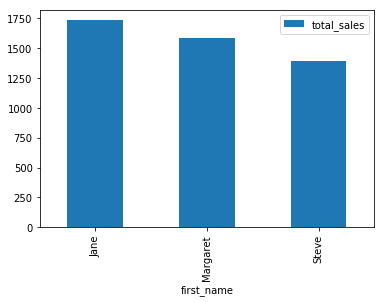

In [8]:
df = run_query(q) 
df.plot(x="first_name", y="total_sales", kind="bar")

### Analyzing Sales by Country

In [9]:
# When customer count for a country = 1, change it to "other"
c = '''
CREATE VIEW purchase_data AS
SELECT
    CASE 
        WHEN 
        (
        SELECT count(*)
        FROM customer
        WHERE country = c.country
        ) = 1 THEN "Other"
        ELSE country
    END as country_and_other,
    COUNT(DISTINCT c.customer_id) AS toal_customers,
    SUM(i.total) AS total_spent,
    SUM(i.total)/COUNT(DISTINCT c.customer_id) AS avg_spent_per_customer,
    SUM(i.total)/COUNT(c.customer_id) AS avg_spent_per_order 
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY country_and_other
ORDER BY total_spent DESC
'''

run_command(c)

In [10]:
q = '''
SELECT *
FROM 
    (
    SELECT 
        pd.*,
        CASE
            when pd.country_and_other = "Other" THEN 1
            ELSE 0
        END AS sort
        FROM purchase_data AS pd
    )
ORDER BY sort ASC
'''

run_query(q)

,country_and_other,toal_customers,total_spent,avg_spent_per_customer,avg_spent_per_order,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


### Visualizing Sales by Country

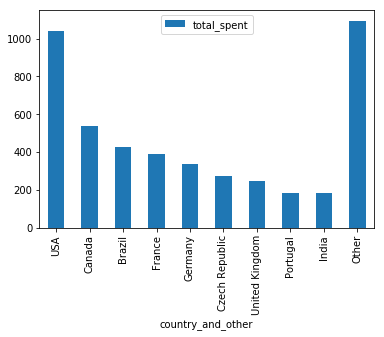

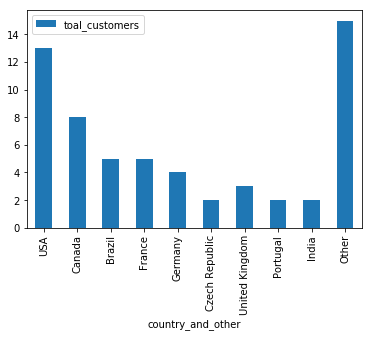

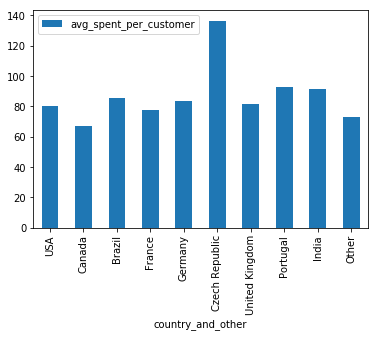

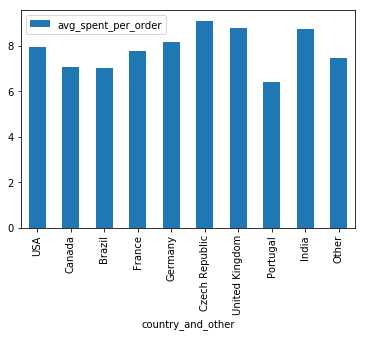

In [12]:
df = run_query(q) 
df.plot(x="country_and_other", y="total_spent", kind="bar")
df.plot(x="country_and_other", y="toal_customers", kind="bar")
df.plot(x="country_and_other", y="avg_spent_per_customer", kind="bar")
df.plot(x="country_and_other", y="avg_spent_per_order", kind="bar")